# 3. 检索陷阱


## 目录
- [ 3.1 - 可视化技巧](#31)
- [ 3.2 - 相似性和干扰项](#32)
- [ 3.3 - 总结](#33)

在这一节中，我们将学习有关使用向量进行检索的一些陷阱。通过几个例子，我们将会发现简单的向量搜索是难以满足AI应用的需求的。

## 3.1 可视化技巧

首先，我们来导入要用到的数据：

In [1]:
from helper_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

## 如果报错：SLError:(MaxRetryEror("SOCKSHTTPSomectionpool(host='huggingface.co', port-443)，注意挂上梯子并添加以下代码：
# import os

# os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890' # 7890改为自己的梯子端口
# os.environ["HTTP_PROXY"]  = 'http://127.0.0.1:7890'

# 指定嵌入函数，将文本转换为嵌入矩阵
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='./data/microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

d:\Anaconda\envs\chroma\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Anaconda\envs\chroma\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


349

接下来我们将用UMAP对嵌入（embedding）矩阵进行可视化，以更好地观察嵌入矩阵元素之间的关系。

UMAP（Uniform Manifold Approximation and Projection）是一种用于降维和数据可视化的算法，类似于 PCA、t-SNE（t-distributed Stochastic Neighbor Embedding）等降维方法，相比 t-SNE 有一些改进，使其在某些情况下更加高效且能够保留数据的全局结构。

安装方式：`pip install umap-learn`。注意是安装`umap-learn`而不是`umap`。

In [2]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

d:\Anaconda\envs\chroma\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [3]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    # 为保证结果可复现，逐个进行umap转换
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

这里`embeddings`矩阵的维度高达384，是一个典型的高维空间，非常复杂，难以观察。因此我们用`UMAP`方法将其投影到二维平面，方便可视化。

In [4]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [04:07<00:00,  1.41it/s]


In [5]:
print(f'Embeddings shape: {np.array(embeddings).shape}')
print(f'Embeddings shape: {projected_dataset_embeddings.shape}')

Embeddings shape: (349, 384)
Embeddings shape: (349, 2)


投影到二维平面后，我们就可以通过散点图来观察不同点之间的关系了。

一般来说，离得越近的两个点，它们的语义相似度越高，反之越低。

(-3.78463613986969, 8.158381581306458, 6.367111563682556, 12.134053349494934)

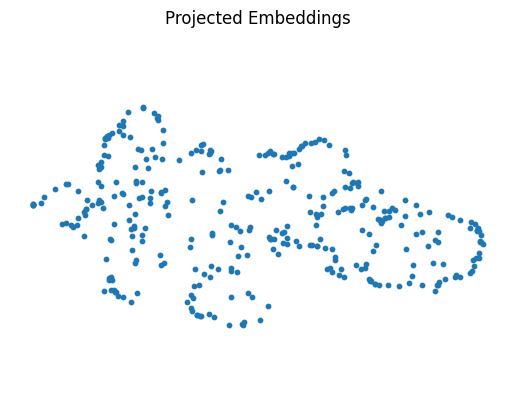

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

## 3.2 相似性和干扰项

接下来，我们将通过几个例子来说明为何简单的向量检索难以满足AI应用需求。

首先，我们来问问总收入是多少。

In [25]:
query = "What is the total revenue?"
query_cn = "总收入是多少？" # 因为这是一个英文文档，中文query的查询结果相对英文query会差一些

# 输入query，返回 n_results 个最相关的查询结果，results 是一个字典，包含了查询结果的文档和嵌入矩阵（方便后续可视化）
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

# 检索结果
retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

revenue, classified by significant product and service offerings, was
as follows : ( in millions ) year ended june 30, 2022 2021 2020 server
products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office
products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22,
488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8,
077 search and news advertising 11, 591 9, 267 8, 524 enterprise
services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291
4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast
certain previously reported amounts in the table above to conform to
the way we internally manage and monitor our business.

74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in millio

可以看到检索结果和收入基本上是相关的，但也有一些可能与收入无直接关系的内容，比如成本等。

接下来我们将查询（即用户的提问）、检索结果、文档数据的嵌入都投影到二维平面，来看看他们的关系如何。

In [26]:
query_embedding = embedding_function([query])[0]  # 查询的嵌入
retrieved_embeddings = results['embeddings'][0]   # 检索的嵌入

# UMAP降维（投影到二维平面）
projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


(-3.78463613986969, 8.158381581306458, 6.367111563682556, 12.134053349494934)

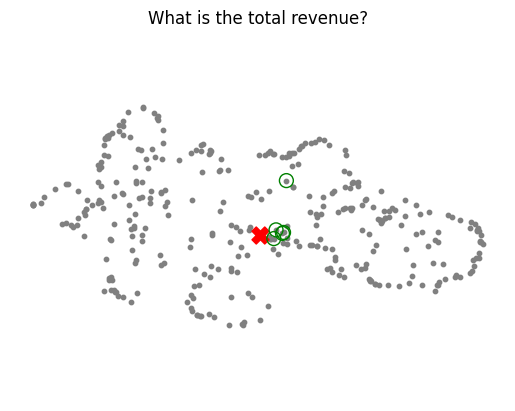

In [27]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

上图中，红色的“×”即为我们的查询（query），绿色圆圈圈住的点为检索结果。

注意：这里我们将高维空间压缩到了二维空间，所以这个可视化结果并不总是完美的。

可以看到大部分检索结果都围绕在query四周，但也存在一些离群点，这就是问题所在。

我们用来嵌入查询和嵌入数据的嵌入模型在我们实际检索信息时并不知道我们要回答的任务或查询。

因此，检索系统可能不按照我们的期望执行的原因是：**我们要求嵌入模型使用一个只有一般性表示的方式去执行特定的任务**。

换一个问题试试：关于人工智能（AI）的策略是什么？

In [28]:
query = "What is the strategy around artificial intelligence (AI) ?"
query_cn = "关于人工智能（AI）的策略是什么？" 
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

culture of trust can help navigate the challenges the world faces
today. organizations of all sizes have digitized business - critical
functions, redefining what they can expect from their business
applications. customers are looking to unlock value while simplifying
security and management. from infrastructure and data, to business
applications and collaboration, we provide unique, differentiated value
to customers. we are building a distributed computing fabric – across
cloud and the edge – to help every organization build, run, and manage
mission - critical workloads anywhere. in the next phase of innovation,
artificial intelligence ( “ ai ” ) capabilities are rapidly advancing,
fueled by data and knowledge of the world. we are enabling metaverse
experiences at all layers of our stack, so customers can more
effectively model, automate, simulate, and predict changes within their
industrial

every organization turn its data into predictive and analytical power.
with our new microsoft 

可以看到AI在大多数检索结果中都被提到，但也有几个结果与AI策略无关。

接下来进行可视化。

In [16]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


(-3.78463613986969, 8.158381581306458, 6.367111563682556, 12.134053349494934)

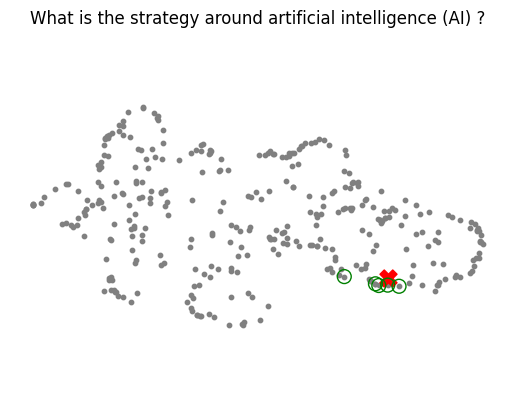

In [17]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

可以看到检索结果和我们的查询离得非常近，和实际结果对得上。

我们再来看另一个查询：在研发方面的投资是多少？

In [19]:
query = "What has been the investment in research and development?"
query_cn = "在研发方面的投资是多少？"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

• operating expenses increased $ 1. 5 billion or 14 % driven by
investments in gaming, search and news advertising, and windows
marketing. operating expenses research and development ( in millions,
except percentages ) 2022 2021 percentage change research and
development $ 24, 512 $ 20, 716 18 % as a percent of revenue 12 % 12 %
0ppt research and development expenses include payroll, employee
benefits, stock - based compensation expense, and other headcount -
related expenses associated with product development. research and
development expenses also include third - party development and
programming costs, localization costs incurred to translate software
for international markets, and the amortization of purchased software
code and services content. research and development expenses increased
$ 3. 8 billion or 18 % driven by investments in cloud engineering,
gaming, and linkedin. sales and marketing

competitive in local markets and enables us to continue to attract top
talent from ac

在研发方面的投资是多少是一个非常一般性的查询，应该在年度报告中有所体现。

从检索结果来看，第一个检索结果答到了研发投入的具体数字，但后面的几个结果存在不少**干扰项**。

干扰项是指与查询实际上无关的结果，之所以称之为干扰项，是因为**如果将这些信息传递给大型语言模型来完成RAG任务，模型往往会被这些信息分散注意力，导致输出次优的结果**。

干扰项导致的模型不良行为对于用户和开发者来说都很难诊断和调试。

因此，让检索系统更加健壮，返回相关结果而不返回干扰项对于模型来说非常重要。

接下来我们将结果进行可视化。

In [20]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


(-3.78463613986969, 8.158381581306458, 6.367111563682556, 12.134053349494934)

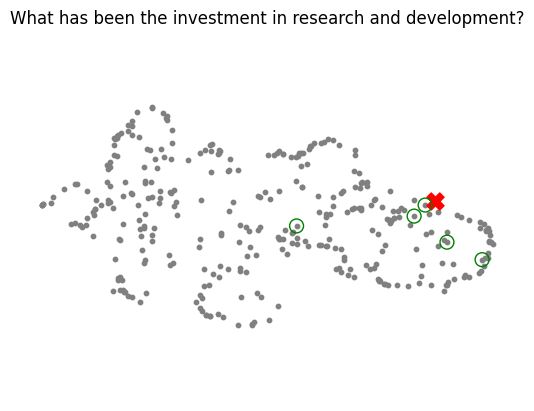

In [21]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

可以看到这个结果更加分散。

因为这是一种几何类型的数据，想象一下所有的数据是一个位于高维空间中的点云。

**落在点云内部的查询可能会找到最近邻，它们在点云内部密集而紧密地靠在一起，但是落在点云外部的查询可能会找到来自该点云许多不同部分的最近邻，因此它们更加分散。**

最后我们来尝试换一个与文档无关的话题。

In [22]:
query = "What has Michael Jordan done for us lately?"
query_cn = "迈克尔·乔丹最近做了什么？"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

we use metrics in assessing the performance of our business and to make
informed decisions regarding the allocation of resources. we disclose
metrics to enable investors to evaluate progress against our ambitions,
provide transparency into performance trends, and reflect the continued
evolution of our products and services. our commercial and other
business metrics are fundamentally connected based on how customers use
our products and

18 total rewards we develop dynamic, sustainable, market - driven, and
strategic programs with the goal of providing a highly differentiated
portfolio to attract, reward, and retain top talent and enable our
employees to thrive. these programs reinforce our culture and values
such as collaboration and growth mindset. managers evaluate and
recommend rewards based on, for example, how well we leverage the work
of others and contribute to the success of our colleagues. we monitor
pay equity and career progress across multiple dimensions. as part of
our eff

显而易见，乔丹和微软的年度报告没有任何关联，检索结果里也确实没有提到他。

但是，如果我们将检索结果用作RAG任务的一部分，LLM的回答将完全基于这些干扰项得到，这就容易出现牛头不对马嘴的情况。

因此，我们需要一种处理无关查询和无关结果的方法。

我们再来看一下投影结果：

In [23]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


(-3.78463613986969, 8.158381581306458, 6.367111563682556, 12.134053349494934)

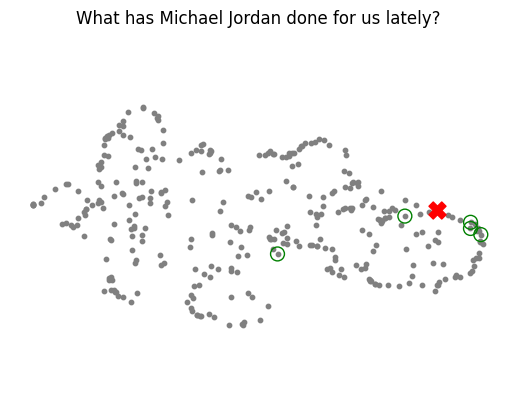

In [24]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

可以看到关于迈克尔·乔丹的结果到处都是，因为查询与我们数据集中的任何数据都毫无关联。

接下来你也可以尝试基于这些代码，换一个查询，可视化一下查询结果，看看它们如何影响返回结果的结构，是否可以使查询落在数据集的不同部分。

<a name='33'></a>
## 3.3 总结

在这个实验中，我们学到了：

- 如何用`UMAP`将高维Embedding向量投影到二维平面并进行可视化；
- **简单的向量检索可能会返回一些无关答案造成干扰**。

在下一个实验中，我们将向你展示通过使用一种称为查询扩展的技术来改善LLMs查询质量的技巧。
